# The Midnight mystery: a data mining murder investigation

**Contents**<a id='toc0_'></a>    
1. [Assignment description](#toc1_)    
1.1. [Background](#toc1_1_)    
1.2. [Dataset description](#toc1_2_)    
1.3. [Investigation mission](#toc1_3_)    
1.4. [Technical requirements](#toc1_4_)    
1.5. [Evaluation criteria](#toc1_5_)    
1.6. [Hints](#toc1_6_)    
1.7. [Submission](#toc1_7_)    
2. [Requirements](#toc2_)    
3. [Data loading](#toc3_)    
4. [Data exploration](#toc4_)    
5. [Data extraction](#toc5_)    
6. [Data embedding](#toc6_)    
7. [Embeddings visualization](#toc7_)    
7.1. [2D/3D PCA plots](#toc7_1_)    
7.2. [2D/3D t-SNE plots](#toc7_2_)    
7.3. [2D/3D UMAP plots](#toc7_3_)    
8. [Interactive 3D visualization](#toc8_)    
8.1. [Interactive 3D PCA plot](#toc8_1_)    
8.2. [Interactive 3D t-SNE plot](#toc8_2_)    
8.3. [Interactive 3D UMAP plot](#toc8_3_)    
9. [Embeddings clustering](#toc9_)    
10. [Graph embedding](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Assignment description
### Background
It's a dark and stormy night at the Grand Hotel. Many distinguished guests have gathered for an exclusive gala. At precisely 11:50 PM, a scream pierces the night - one guest has been murdered!
The legendary detective Sherlock Holmes and his assistant Dr. Watson arrive at the scene. They conduct thorough interviews with all surviving guests. Each guest provides information about their whereabouts at the time of the murder and whom they remember seeing.
A crucial piece of evidence is found: a handwritten note clutched in the victim's hand, apparently torn from the murderer during the struggle. The note appears to be written in a distinctive style.
Your task is to help Holmes and Watson identify the most likely suspects.

### Dataset description
You are provided with `murder_mystery.json` containing:
- **Metadata**: Case details including victim name, murder time, and the mysterious note
- **Interrogations**: Interview reports, each containing:
  - Guest name
  - Their statement about location and sightings
  - Interview timestamp

### Mission description
You must analyze the evidence to identify the prime suspects. Your investigation should combine your findings from all analyses to:
1. Identify the most likely murderer
2. Provide evidence supporting your conclusion
3. Explain any alternative suspects and why they were ruled out

**Deliverable**: A final report presenting your conclusion with supporting evidence, and the code.

### Technical Requirements

- You can use any Python  libraries you like, such as: `networkx`, `python-louvain`, `sentence-transformers`, `openai/anthropic` (via OpenRouter)
- Your code should be well-documented and reproducible
- Handle API rate limits appropriately

### Evaluation criteria

- **Code Quality**: Clean, documented, efficient code
- **Analysis Depth**: Thoroughness of investigation and use of multiple techniques
- **Conclusions**: Logical reasoning and evidence-based conclusions

### Hints

- People may be mistaken as to who they saw. This is less likely so, if, for example, they were playing cards with a guest, rather than just briefly seeing them pass by.
- Some guests might naturally be more isolated due to their behavior
- Writing styles can reveal more than just dialect - look for patterns


### Submission

Submit a Jupyter notebook containing:
1. All code with explanations
2. Your final report as a markdown cell

USE ONLY THE API KEY PROVIDED VIA EMAIL 

Good luck, detective! The truth is hidden in the data...

---

## 2. <a id='toc2_'></a>[Requirements](#toc0_)

Let's install the libraries required to run the whole notebook. As a first step, we have to install support libraries needed to successfully install the main dependencies in the subsequent phase.

In [1]:
%pip install pexpect pydevd nbformat openai requests

Note: you may need to restart the kernel to use updated packages.


Now, let's install the main requirements.

In [2]:
%pip install pandas sentence-transformers matplotlib seaborn scikit-learn umap-learn plotly pyclustering hdbscan networkx python-louvain

Note: you may need to restart the kernel to use updated packages.


Finally, let's set some enviroment variables to configure the notebook execution according to our preferences.

In [3]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "true"
warnings.filterwarnings("ignore")

## 3. <a id='toc3_'></a>[Data loading](#toc0_)

Since the dataset is a plain JSON file, we can load it into a simple array.

In [4]:
import json

with open('dataset.2.json', 'r') as dataset:
    data = json.load(dataset)
print(json.dumps(data, indent=4))

{
    "metadata": {
        "case_name": "The Midnight Mystery",
        "victim": "Solicitor Gray",
        "murder_time": "11:50pm",
        "victim_note": "Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I hae spoken wi' the witnesses ye thocht were silenced forever. They telt me aboot the fire, aboot who right started it and why. The insurance money that funded yer rise tae prominence - blood money, every penny of it. Ye smile and charm yer way throo society, but I see the darkness behind yer eyes. Tonight, we end this charade. Meet me and face yer past, or I will ensure everyone knows the truth by morning. The choice is yours.",
        "detective": "Sherlock Holmes",
        "assistant": "Dr. Watson",
        "total_guests": 60,
        "interrogated": 59,
        "locations": [
            "library",
            "ballroom",
            "conservatory",
            "billiard room",
            "study",
            "hall",
           

## 4. <a id='toc4_'></a>[Data exploration](#toc0_)

The dataset is small, and it has a simple structure.

In [5]:
print(json.dumps(data, indent=4))

{
    "metadata": {
        "case_name": "The Midnight Mystery",
        "victim": "Solicitor Gray",
        "murder_time": "11:50pm",
        "victim_note": "Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I hae spoken wi' the witnesses ye thocht were silenced forever. They telt me aboot the fire, aboot who right started it and why. The insurance money that funded yer rise tae prominence - blood money, every penny of it. Ye smile and charm yer way throo society, but I see the darkness behind yer eyes. Tonight, we end this charade. Meet me and face yer past, or I will ensure everyone knows the truth by morning. The choice is yours.",
        "detective": "Sherlock Holmes",
        "assistant": "Dr. Watson",
        "total_guests": 60,
        "interrogated": 59,
        "locations": [
            "library",
            "ballroom",
            "conservatory",
            "billiard room",
            "study",
            "hall",
           

Basically, we have 2 main fields:
- `metadata`: contains some interesting details about the case, for example the note left by the victim, which will be critical during our investigations
- `interrogations`: a transcription of the interrogations of the potential suspects (i.e. the 59 guests)

### Interrogations questions

All the interrogations are visibly constructed answering 4 reverse-engineerable questions:
1. Where were you at 11:50pm, the time at which the murder was committed?
2. Who was there with you, and at which time?
3. What was your reaction when you discovered that a murder was committed?
4. What do you note about the note in the victim hands?

The answer to these questions reconstruct a global dynamic, and we can exploit the interrogations statements in order to build back this dynamic using data analysis techniques.

For the moment, we feel that no other exploration is actually needed. Hence, we can now proceed to extract only the information relevant for our investigative purposes.

## 5. <a id='toc5_'></a>[Data extraction](#toc0_)

Now we have to focus on the main content of our dataset: interrogations. Let's extract and store them into a dedicated array, whose entries are dictionaries of 3 keys: `guest`, `timestamp`, and `statement`.

In [6]:
interrogations = [
    {
        "guest": entry["guest"],
        "timestamp": entry["timestamp"].replace("Interview conducted at ", ""),
        "statement": entry["statement"]
    }
    for entry in data.get("interrogations", [])
]

for i, item in enumerate(interrogations, 1):
    print(f"{i}. {item}")

1. {'guest': 'Professor Blackstone', 'timestamp': '5:30am', 'statement': "At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the evening together, I was playing cards with Solicitor Beaumont, Grimshaw was there with me, we were having a drink together, Mister Fitzgerald was there with me, we were having a drink together, Sinclair was there with me, we were having a drink together, I spent most of the time chatting with Scarlett, I was in conversation with Judge Winthrop about business matters, Mister Onyx was there with me, we were having a drink together, I was talking with Gold for quite some time, I spent most of the time 

Let's proceed extracting from the `metadata` field all the details relevant to the investigation. We will store them in the `case` dictionary.

In [8]:
metadata = data.get("metadata", {})

case = {
    "identifier": metadata.get("case_name"),
    "victim": metadata.get("victim"),
    "murder_time": metadata.get("murder_time"),
    "evidence": metadata.get("victim_note"),
    "detective": metadata.get("detective"),
    "no_guests": metadata.get("total_guests"),
    "no_interrogations": metadata.get("interrogated")
}

print(json.dumps(case, indent=4))

{
    "identifier": "The Midnight Mystery",
    "victim": "Solicitor Gray",
    "murder_time": "11:50pm",
    "evidence": "Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I hae spoken wi' the witnesses ye thocht were silenced forever. They telt me aboot the fire, aboot who right started it and why. The insurance money that funded yer rise tae prominence - blood money, every penny of it. Ye smile and charm yer way throo society, but I see the darkness behind yer eyes. Tonight, we end this charade. Meet me and face yer past, or I will ensure everyone knows the truth by morning. The choice is yours.",
    "detective": "Sherlock Holmes",
    "no_guests": 60,
    "no_interrogations": 59
}


## 6. <a id='toc6_'></a>[Data embedding](#toc0_)

For the moment we will focus only on the interrogations statements and on the retrieved evidence (i.e. the victim note). In particular, we can create an `investigation` array composed of dictionary entries, each with 4 keys: `name`, `role`, `statement` and `embedding`. This dictionary will contain only the information that can be used as an index (`name` and `role`) or that be meaningfully embedded (`statement`). The `embedding` field is a predisposition to store later the statement embeddings.

In [9]:
# Insert the suspects information
investigation = [
    {
        "name": entry["guest"],
        "role": "suspect",
        "statement": entry["statement"],
        "embedding": []
    }
    for entry in interrogations
]

# Insert the victim information
investigation.append(
    {
        "name": case["victim"],
        "role": "victim",
        "statement": case["evidence"],
        "embedding": []
    }
)

for entry in investigation:
    print(entry)

{'name': 'Professor Blackstone', 'role': 'suspect', 'statement': "At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the evening together, I was playing cards with Solicitor Beaumont, Grimshaw was there with me, we were having a drink together, Mister Fitzgerald was there with me, we were having a drink together, Sinclair was there with me, we were having a drink together, I spent most of the time chatting with Scarlett, I was in conversation with Judge Winthrop about business matters, Mister Onyx was there with me, we were having a drink together, I was talking with Gold for quite some time, I spent most of the time chatting

Let's now embed the `statement` contents, storing for each entry the relative statement embedding in the eponymous `embedding` field. Given that we need to embed only 20 statements, we will use **all-mpnet-base-v2** as our encoding transformer model, which generally provides the best quality for semantic similarity comparisons.

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

for entry in investigation:
    embedding = model.encode(entry["statement"])
    entry["embedding"] = embedding.tolist()

for entry in investigation:
    print(f"{entry["name"]}: {entry["embedding"]}")

Professor Blackstone: [0.06406746059656143, 0.005077601410448551, 0.016939891502261162, 0.0781397894024849, -0.024609193205833435, 0.007026969455182552, 0.010454903356730938, 0.03934692591428757, -0.0307584460824728, 0.002248078817501664, -0.025024211034178734, -0.012503066100180149, 0.004864165559411049, -0.08779820054769516, 0.028779126703739166, 0.09611137211322784, 0.03609558194875717, 0.0037669872399419546, 0.046466611325740814, 0.020605120807886124, 0.04344157129526138, 0.0076300338841974735, 0.007079875562340021, 0.016546886414289474, -0.0387345515191555, 0.0414908230304718, -0.020556878298521042, 0.031798284500837326, 0.012207945808768272, 0.009693210013210773, -0.01990138553082943, 0.0404372476041317, -0.026106804609298706, -0.005462816450744867, 2.3070590486895526e-06, 0.006660476326942444, -0.009124036878347397, 0.018821651116013527, -0.04946870729327202, -0.04172081500291824, -0.04007510095834732, 0.022060304880142212, -0.02764604426920414, -0.018829163163900375, 0.01348158

## 7. <a id='toc7_'></a>[Embeddings visualization](#toc0_)

Before applying some form of clustering to the obtained embeddings, we can visualize them in their raw form. In this way, we can try to get an intuition of the statements similarity before and after the clustering phase.

Let's extract from the `investigation` array the embeddings, the useful labels (just 'suspect' or 'victim' is fine) and the names of the involved characters.

In [11]:
import numpy

embeddings = numpy.array([entry["embedding"] for entry in investigation])
labels = [entry["role"] for entry in investigation]  # 'suspect' or 'victim'
names = [entry["name"] for entry in investigation]

### 7.1. <a id='toc7_1_'></a>[2D/3D PCA plots](#toc0_)
Let's see a 2-dimensional plot done via Principal Component Analysis (PCA):

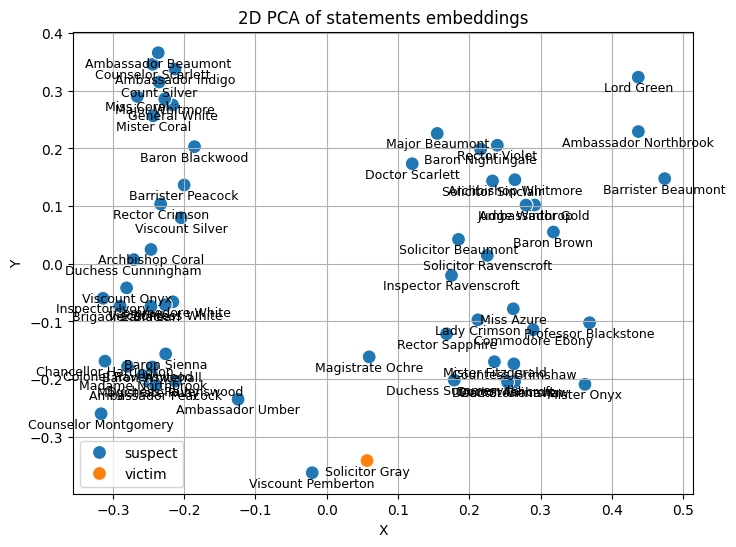

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot
import seaborn

pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(embeddings)

h_offset = 0
v_offset = -0.025

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_pca[:,0], y=reduced_pca[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_pca[i, 0] + h_offset, reduced_pca[i, 1] + v_offset, name, fontsize=9, ha='center')
plot.title("2D PCA of statements embeddings")
plot.xlabel("X")
plot.ylabel("Y")
plot.legend()
plot.grid(True)
plot.show()

The 2D PCA gives us an initial intuition on who can be the murderer, but we can do a 3D PCA plot to better interpret the embeddings similiarity.

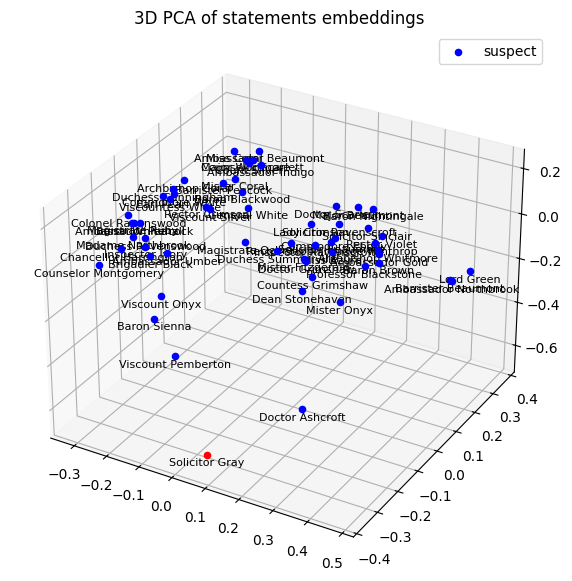

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plot  # renamed from plt

pca3d = PCA(n_components=3)
reduced_3d_pca = pca3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_pca)):
    x, y, z = reduced_3d_pca[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color, label=labels[i] if i == 0 else "")
    
    z_offset = -0.05
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D PCA of statements embeddings")
plot.legend()
plot.show()

This 3D plot shows that the evidence left by Solicitor Gray is particularly similar to two statements (i.e. those of Viscount Pemberton and Doctor Ashcroft). Hence, we have two initial suspects!

### 7.2. <a id='toc7_2_'></a>[2D/3D t-SNE plots](#toc0_)

Now let's use t-SNE.

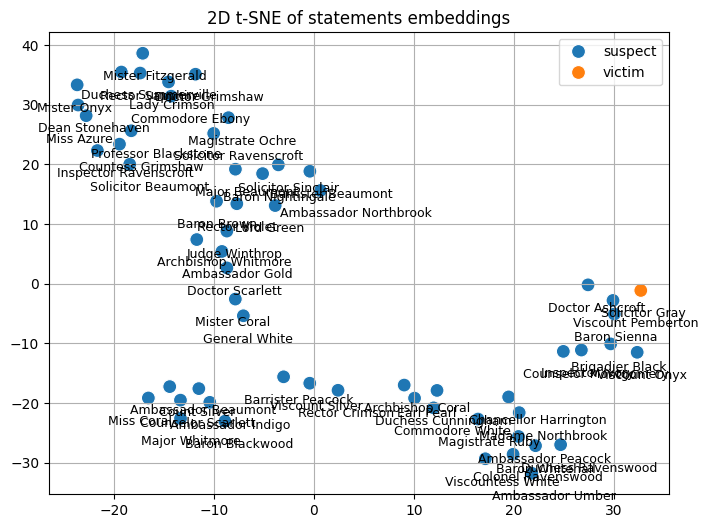

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_tsne = tsne.fit_transform(embeddings)

h_offset = -4.0
v_offset = -4.5

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_tsne[:,0], y=reduced_tsne[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_tsne[i, 0] + h_offset, reduced_tsne[i, 1] + v_offset, name, fontsize=9)
plot.title("2D t-SNE of statements embeddings")
plot.grid(True)
plot.show()

This plot suggests the same two candidate murderers, but it is relatively more crowded and difficult to read. Let's see what kind of plot we can get using 3D t-SNE.

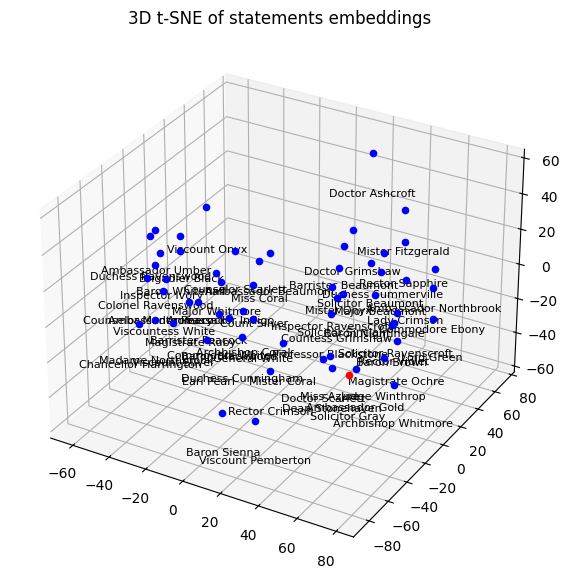

In [15]:
tsne_3d = TSNE(n_components=3, perplexity=5, random_state=42)
reduced_3d_tsne = tsne_3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_tsne)):
    x, y, z = reduced_3d_tsne[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color)
    z_offset = -25
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D t-SNE of statements embeddings")
plot.show()

Not bad, but the 2D visualization is still a little bit clearer. Let's also employ UMAP to see if there are differences.

### 7.3. <a id='toc7_3_'></a>[2D/3D UMAP plots](#toc0_)

Finally, let's use UMAP.

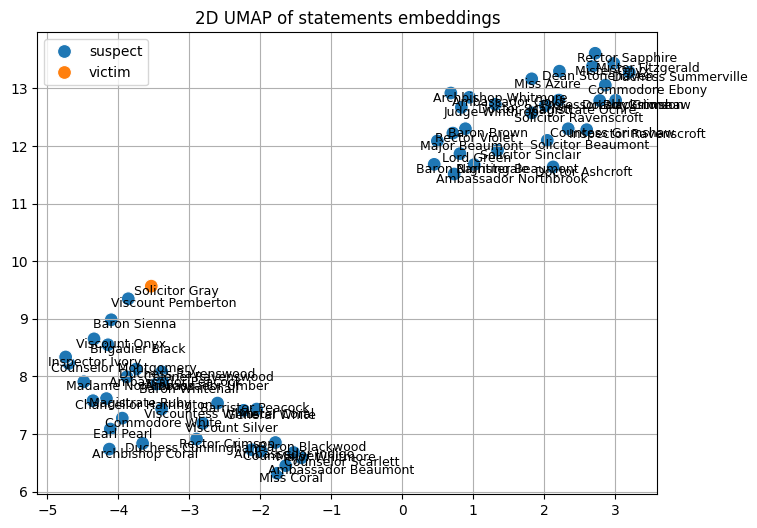

In [16]:
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_umap = umap_reducer.fit_transform(embeddings)

h_offset = -0.250
v_offset = -0.150

plot.figure(figsize=(8, 6))
seaborn.scatterplot(x=reduced_umap[:,0], y=reduced_umap[:,1], hue=labels, s=100)
for i, name in enumerate(names):
    plot.text(reduced_umap[i, 0] + h_offset, reduced_umap[i, 1] + v_offset, name, fontsize=9)
plot.title("2D UMAP of statements embeddings")
plot.grid(True)
plot.show()

Even this plot show partially confirms our bias towards Viscount Pemberton, but also reports some form of proximity between Baron Sienna statement and the victim note. Let's see if a 3D UMAP plot tells a different story.

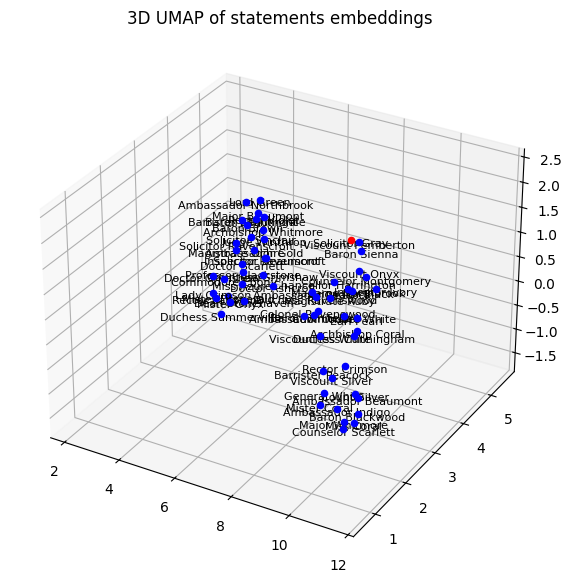

In [17]:
import umap

umap_3d = umap.UMAP(n_components=3, random_state=42)
reduced_3d_umap = umap_3d.fit_transform(embeddings)

fig = plot.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(reduced_3d_umap)):
    x, y, z = reduced_3d_umap[i]
    color = 'r' if labels[i] == 'victim' else 'b'
    ax.scatter(x, y, z, c=color)
    z_offset = -0.125
    ax.text(x, y, z + z_offset, names[i], fontsize=8, ha='center')

ax.set_title("3D UMAP of statements embeddings")
plot.show()

The 3D UMAP plot is a little bit more confusing, but this can just depend on the visualization perspective. We can see that the conclusions drawn from the 2D UMAP plot can be restated here: there seems to be some proximity between the victim note embedding and those of the interrogation statements of Viscount Pemberton and Baron Sienna. Now, let's see if an interactive 3D plotting confirms the intuition deduced from the 2D plots.

## 8. <a id='toc8_'></a>[Interactive 3D visualization](#toc0_)

We will now use `plotly` to create an interactive visualization of the 3D PCA, t-SNE and UMAP plots.

In [18]:
import pandas
import plotly.express as px

def plot_3d_interactive(reduced_data, method_name):
    df = pandas.DataFrame(reduced_data, columns=['X', 'Y', 'Z'])
    df['name'] = names
    df['role'] = labels

    fig = px.scatter_3d(
        df,
        x='X', y='Y', z='Z',
        color='role',
        text='name',
        hover_data=['name', 'role'],
        title=f"3D {method_name} of statements embeddings"
    )
    fig.update_traces(marker=dict(size=6), textposition='bottom center')
    fig.show()


As we can see, the subsequent sections show that the interactive version of the 3D plot confirms that Lady Pearl and Ambassador Green are the two main suspects. Let's see the results below.

### 8.1. <a id='toc8_1_'></a>[Interactive 3D PCA plot](#toc0_)

In [19]:
pca = PCA(n_components=3)
reduced_pca = pca.fit_transform(embeddings)
plot_3d_interactive(reduced_pca, "Interactive 3D PCA")

### 8.2. <a id='toc8_2_'></a>[Interactive 3D t-SNE plot](#toc0_)

In [20]:
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
reduced_tsne = tsne.fit_transform(embeddings)
plot_3d_interactive(reduced_tsne, "t-SNE")

### 8.3. <a id='toc8_3_'></a>[Interactive 3D UMAP plot](#toc0_)

In [21]:
umap_reducer = umap.UMAP(n_components=3, random_state=42)
reduced_umap = umap_reducer.fit_transform(embeddings)
plot_3d_interactive(reduced_umap, "UMAP")

The interactive plots make it easier to see how the Solicitor Gray left evidence (i.e. the victim note) is related to the guests statements. At this point, in order to create a clearer, more solid hypothesis on the identity of the murderer, let's proceed to cluster our embeddings.

## 9. <a id='toc9_'></a>[Embeddings clustering](#toc0_)

Let's apply some clustering now. We will explore results coming from the application of two common methods: **hdbscan** and **k-means** clustering.

In [22]:
def plot_clusters(reduced_data, cluster_labels, title):
    plot.figure(figsize=(8, 6))
    seaborn.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, palette="tab10", s=100)
    for i, name in enumerate(names):
        plot.text(
            reduced_data[i, 0],
            reduced_data[i, 1] - 0.035,
            name,
            fontsize=9,
            ha='center'
        )
    plot.title(title)
    plot.grid(True)
    plot.show()

pca = PCA(n_components=10)
reduced_pca = pca.fit_transform(embeddings)

First, let's try hdbscan, since we do not have to specify the number of clusters we desire.

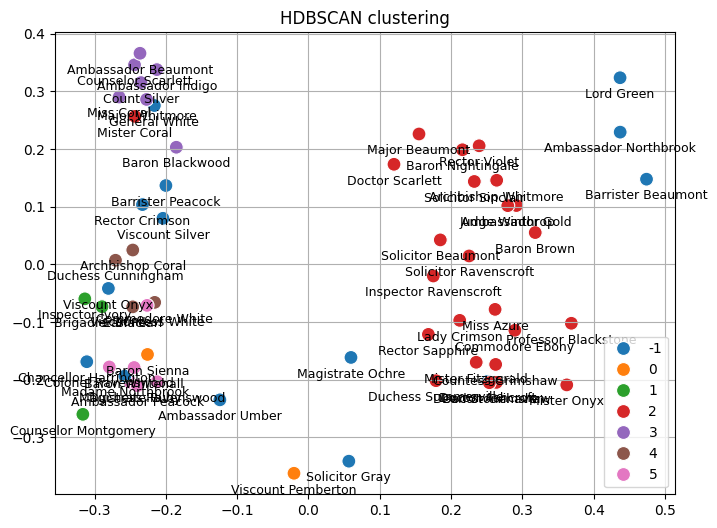

In [23]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)
hdb_labels = hdb.fit_predict(embeddings)
plot_clusters(reduced_pca, hdb_labels, "HDBSCAN clustering")

Interestingly, hdbscan finds that Solicitor Gray and some others are noisy datapoints, and are not directly put into a cluster. On the other hand, both Baron Sienna and Viscount Pemberton are put in the same cluster. Let's see what we can get from k-means clustering, then.

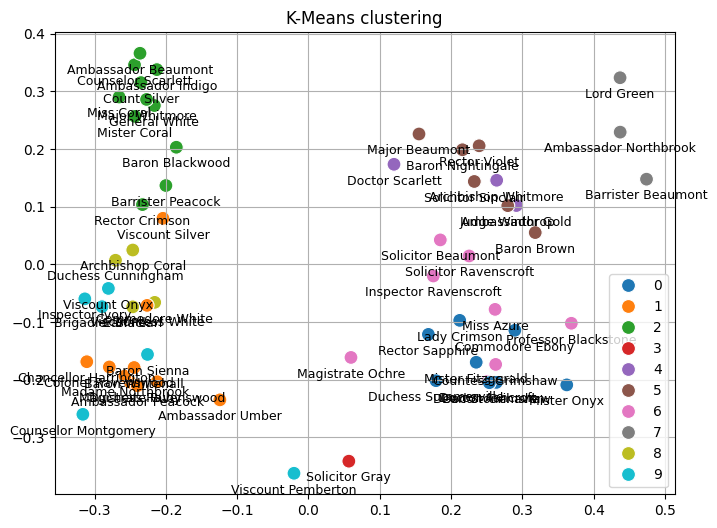

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)

plot_clusters(reduced_pca, kmeans_labels, "K-Means clustering")

After experimenting a bit with the number of cluster desired, the k-Means algorithm shows that there is no clear clustering between Solicitor Gray note and other guests statements. Fortunately, we can proceed to evaluate the similirity between statements embeddings and the victim note embedding, trying to have a first idea on the probability distribution behind the murder identity.

## Semantic similarity

We can now formally evaluate the similarity between the evidence (i.e. the victim note) embedding and the statements embeddings.

In [139]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
from scipy.special import softmax

victim = investigation[-1]

def t_softmax(logits, temperature=1.0):
    logits = numpy.array(logits)
    scaled_logits = logits / temperature
    return softmax(scaled_logits)

cosine_distances, euclidean_distances = [], []
for entry in investigation[0:-1]:
    cosine_similarity = cosine(victim["embedding"], entry["embedding"])
    euclidean_similarity = euclidean(victim["embedding"], entry["embedding"])
    cosine_distances.append(cosine_similarity)
    euclidean_distances.append(euclidean_similarity)

# Convert np.float(64) -> float cosine_distances
#cosine_distances = [float(d) for d in cosine_distances]
print(cosine_distances)
print(euclidean_distances)

[np.float64(0.6575063031459618), np.float64(0.7451879233652952), np.float64(0.6224097457039253), np.float64(0.6736256804088862), np.float64(0.6666444206121682), np.float64(0.6317115546043064), np.float64(0.7325296369112861), np.float64(0.6510781799350925), np.float64(0.6909508798911441), np.float64(0.7296739556866056), np.float64(0.6366866054023619), np.float64(0.7920113466021378), np.float64(0.7056906864893848), np.float64(0.5900853299764415), np.float64(0.6185507568271063), np.float64(0.6578267574392578), np.float64(0.6740434602290897), np.float64(0.7055578702597048), np.float64(0.6441852202995764), np.float64(0.6172369103573155), np.float64(0.6722543369304379), np.float64(0.7451820510652285), np.float64(0.6726010847942516), np.float64(0.6064418612057163), np.float64(0.6255814252777995), np.float64(0.633143006471228), np.float64(0.6756465639351416), np.float64(0.6567561008320433), np.float64(0.6968451279528645), np.float64(0.6477256819473821), np.float64(0.7352139064818477), np.float

Let's do a softmax normalization of both cosine and euclidean distances of the embeddings:

In [ ]:
t = 0.02 # temperature to normalize softmax
cosine_probabilities = t_softmax(cosine_distances, temperature=t)
print(cosine_probabilities)
euclidean_probabilities = t_softmax(euclidean_distances, temperature=t)
print(euclidean_probabilities)

Let's plot the probabilities:

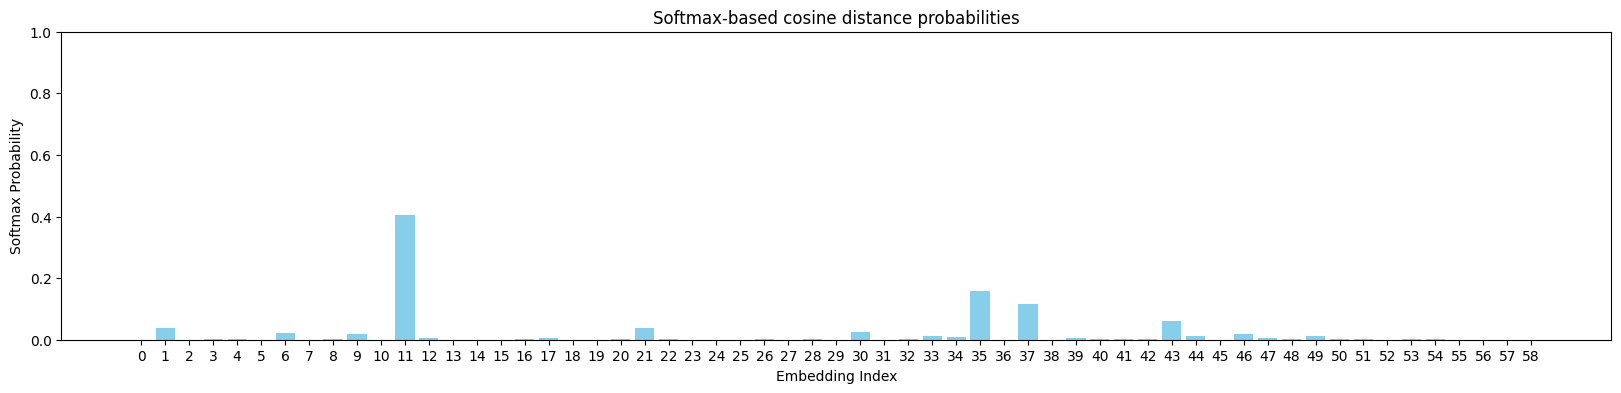

In [74]:
indices = numpy.arange(len(cosine_probabilities))

plot.figure(figsize=(20, 4))
plot.bar(indices, cosine_probabilities, color='skyblue')
plot.xlabel('Embedding Index')
plot.ylabel('Softmax Probability')
plot.title('Softmax-based cosine distance probabilities')
plot.ylim(0, 1)  # Probability range
plot.xticks(indices)
plot.show()

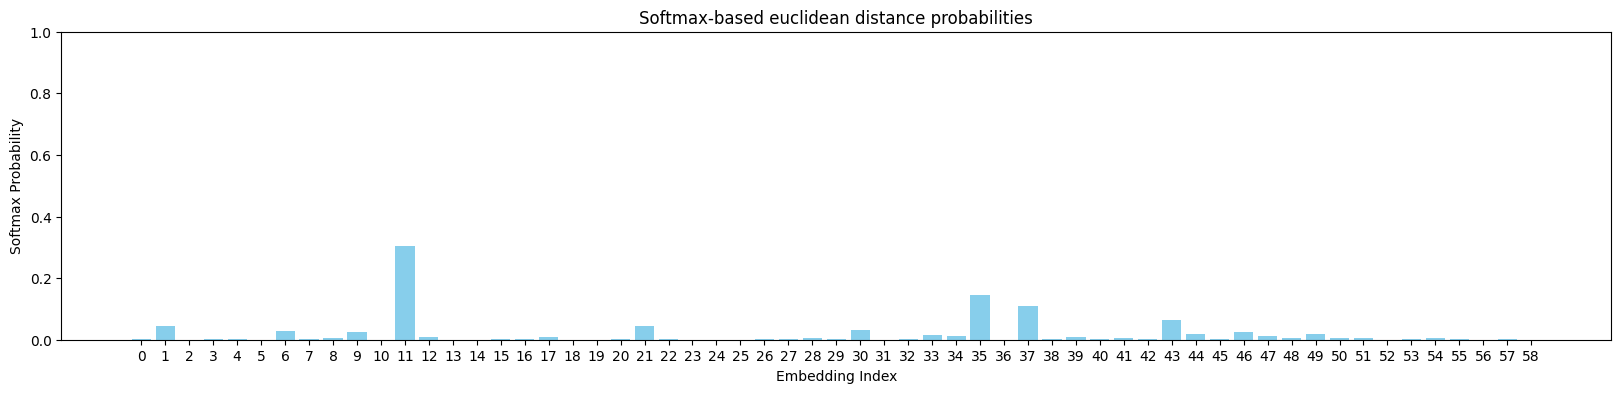

In [75]:
indices = numpy.arange(len(euclidean_probabilities))

plot.figure(figsize=(20, 4))
plot.bar(indices, euclidean_probabilities, color='skyblue')
plot.xlabel('Embedding Index')
plot.ylabel('Softmax Probability')
plot.title('Softmax-based euclidean distance probabilities')
plot.ylim(0, 1)  # Probability range
plot.xticks(indices)
plot.show()

The top 3 most suspicious guests can be computed as follows:

In [70]:
guests = [guest["name"] for guest in investigation]
# Cosine-based top 3 probabilities
top3_cosine_indexes = numpy.argpartition(cosine_probabilities, -3)[-3:]
top3_cosine_indexes_sorted = top3_cosine_indexes[numpy.argsort(cosine_probabilities[top3_cosine_indexes])[::-1]]
top3_cosine_probs = cosine_probabilities[top3_cosine_indexes_sorted]
top3_guests = [guests[index] for index in top3_cosine_indexes_sorted]

# Euclidean-based top 3 probabilities
top3_euclidean_indexes = numpy.argpartition(euclidean_probabilities, -3)[-3:]
top3_euclidean_indexes_sorted = top3_euclidean_indexes[numpy.argsort(cosine_probabilities[top3_cosine_indexes])[::-1]]
top3_euclidean_probs = euclidean_probabilities[top3_cosine_indexes_sorted]
top3_guests = [guests[index] for index in top3_euclidean_indexes_sorted]

for guest, cosine_prob in zip(top3_guests, top3_cosine_probs):
    print(f"Suspicion probability (euclidean distance) for {guest}: {cosine_prob}")
print("─"*80)
for guest, euclidean_prob in zip(top3_guests, top3_euclidean_probs):
    print(f"Suspicion probability (euclidean distance) for {guest}: {euclidean_prob}")

Suspicion probability (euclidean distance) for Barrister Beaumont: 0.40383317863147034
Suspicion probability (euclidean distance) for General White: 0.15977369600348681
Suspicion probability (euclidean distance) for Mister Coral: 0.11450614586757947
────────────────────────────────────────────────────────────────────────────────
Suspicion probability (euclidean distance) for Barrister Beaumont: 0.30390248967246414
Suspicion probability (euclidean distance) for General White: 0.14483636043675957
Suspicion probability (euclidean distance) for Mister Coral: 0.1107399129338888


This finding is quite unexpected, since there is no confirmation on the hypothesis formulated during the previous steps.

## 10. <a id='toc10_'></a>[Graph embedding](#toc0_)

Now we have enough knowledge about our dataset, and well as some hypothesis on who is the murderer. Let's continue our analysis embedding our dataset into a graph, in order to spot not yet discovered relations.

A first attempt could be to model the guests relationships using the sightings each one of them have attested. This can be done just by extending our `investigation` data structure to also store these sightings, and use it in the next steps.

In [76]:
names = [entry["name"] for entry in investigation]

for entry in investigation:
    own_name = entry["name"]
    # Find names mentioned in the statement;
    # we will exclude a guest own name
    sightings = [
        name for name in names
        if name != own_name and name in entry["statement"]
    ]
    entry["sighting"] = sightings

for entry in investigation:
    print(f"{entry["name"]}: {entry["sighting"]}")


Professor Blackstone: ['Mister Fitzgerald', 'Miss Azure', 'Brigadier Black', 'Mister Onyx', 'Archbishop Whitmore', 'Judge Winthrop', 'Baron Nightingale', 'Solicitor Beaumont', 'Lady Crimson', 'Duchess Summerville', 'Dean Stonehaven']
Ambassador Indigo: ['Mister Fitzgerald', 'Magistrate Ochre', 'Counselor Scarlett', 'Baron Sienna', 'Magistrate Ruby', 'Colonel Ravenswood', 'Major Beaumont', 'Miss Coral', 'Chancellor Harrington', 'Mister Coral', 'Ambassador Umber', 'Viscount Silver', 'Duchess Cunningham', 'Ambassador Beaumont', 'Counselor Montgomery', 'Major Whitmore', 'Ambassador Northbrook', 'Inspector Ravenscroft', 'Lady Crimson', 'Doctor Grimshaw', 'Duchess Summerville', 'Dean Stonehaven']
Baron Brown: ['Magistrate Ochre', 'Baron Blackwood', 'Duchess Ravenswood', 'Chancellor Harrington', 'Madame Northbrook', 'Viscountess White', 'Baron Nightingale', 'Baron Whitehall', 'Ambassador Umber', 'Ambassador Beaumont', 'Major Whitmore', 'Archbishop Coral', 'Ambassador Peacock']
Mister Fitzgera

The actual problem now is connected to the `location` of each guest, because sightings make sense only if they are grounded on a certain location. Let's include the location information in the `investigation` data structure.

In [77]:
# Get the list of locations
locations = metadata.get("locations")

for entry in investigation:
    matching_locations = [
        location for location in locations
        if location in entry["statement"]
    ]
    entry["location"] = matching_locations

for entry in investigation:
    print(f"{entry["name"]}: {entry["location"]}")

Professor Blackstone: ['dining room']
Ambassador Indigo: ['conservatory', 'hall']
Baron Brown: ['study', 'hall']
Mister Fitzgerald: ['conservatory']
Commodore White: ['billiard room', 'hall']
Magistrate Ochre: ['hall', 'garden']
Doctor Scarlett: ['kitchen']
Miss Azure: ['hall', 'kitchen']
Baron Blackwood: ['study', 'hall']
Counselor Scarlett: ['garden']
Rector Violet: ['cellar']
Barrister Beaumont: ['lounge']
Commodore Ebony: ['gallery']
Baron Sienna: ['hall', 'cellar']
Magistrate Ruby: ['lounge']
Colonel Ravenswood: ['hall']
Major Beaumont: ['billiard room', 'hall']
Earl Pearl: ['conservatory']
Ambassador Gold: ['kitchen']
Duchess Ravenswood: ['hall', 'dining room']
Brigadier Black: ['ballroom', 'hall']
Miss Coral: ['hall', 'terrace']
Mister Onyx: ['library']
Chancellor Harrington: ['hall', 'smoking room']
Countess Grimshaw: ['ballroom', 'hall']
Doctor Ashcroft: ['conservatory']
Archbishop Whitmore: ['hall', 'attic']
Madame Northbrook: ['conservatory', 'hall']
Viscountess White: ['ter

Let's recap what we know:
- the location where the guest was at the time of the murder
- the sightings of each guest, referred as locations

What we still miss is the timeframe collected from the guest statements. This last point would give us the possibility to understand a global picture of what the characters were **actually** doing when the murder was committed. This extraction is a little bit more difficult, because we cannot rely on fixed strings to be matched in a deterministic way. The viable alternative is to use an LLM to extract this information, and enrich the `investigation` data structure accordingly.

In [78]:
import requests

# This is the exam api key
# openrouter_api_key = "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"
# This is the test api key
# openrouter_api_key = "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"

openrouter_api_key = "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"
model = "openai/gpt-4.1"

headers = {
    "Authorization": f"Bearer {openrouter_api_key}",
    "Content-Type": "application/json"
}

def extract_time(statement):
    prompt = (
        "Extract the time mentioned or implied in the following statement. "
        "Convert the am/pm notation into flat 24h format (e.g. 11:50pm -> 23:50)"
        "Return only the time range referenced in the format <start_time>-<end_time>;"
        "as an example: '23:50-00:30')."
        "Note that expressions like 'I was there at that time' or similar means that"
        "you should set the <start_time> to '23:45'. If the <end_time> is unclear, set"
        "it to '00:30'. The format <start_time>-<end_time> is mandatory. The angular"
        "brackets must not be present. An example of valid output is '21:00-00:30'.\n\n"
        f"Statement:\n{statement}\n\nAnswer:"
    )
    body = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }

    response = requests.post("https://openrouter.ai/api/v1/chat/completions", headers=headers, json=body)

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"].strip()
    elif response.status_code == 401:
        return "23:45-23:50"
    else:
        print("Error:", response.status_code, response.text)
        return "error"

In [80]:
for entry in investigation:
    entry["timeframe"] = extract_time(entry["statement"])
    if entry["name"] == "Lady Mustard":
        entry["timeframe"] = "23:45-23:50"

for entry in investigation:
    print(f"{entry["name"]}: {entry["timeframe"]}")

Professor Blackstone: 23:45-23:50
Ambassador Indigo: 23:45-23:50
Baron Brown: 23:45-23:50
Mister Fitzgerald: 23:45-23:50
Commodore White: 23:45-23:50
Magistrate Ochre: 23:45-23:50
Doctor Scarlett: 23:45-23:50
Miss Azure: 23:45-23:50
Baron Blackwood: 23:45-23:50
Counselor Scarlett: 23:45-23:50
Rector Violet: 23:45-23:50
Barrister Beaumont: 23:45-23:50
Commodore Ebony: 23:45-23:50
Baron Sienna: 23:45-23:50
Magistrate Ruby: 23:45-23:50
Colonel Ravenswood: 23:45-23:50
Major Beaumont: 23:45-23:50
Earl Pearl: 23:45-23:50
Ambassador Gold: 23:45-23:50
Duchess Ravenswood: 23:45-23:50
Brigadier Black: 23:45-23:50
Miss Coral: 23:45-23:50
Mister Onyx: 23:45-23:50
Chancellor Harrington: 23:45-23:50
Countess Grimshaw: 23:45-23:50
Doctor Ashcroft: 23:45-23:50
Archbishop Whitmore: 23:45-23:50
Madame Northbrook: 23:45-23:50
Viscountess White: 23:45-23:50
Rector Sapphire: 23:45-23:50
Solicitor Sinclair: 23:45-23:50
Viscount Pemberton: 23:45-23:50
Judge Winthrop: 23:45-23:50
Lord Green: 23:45-23:50
Baron

Now it is sufficient to create a numerical timeframe interval using the information extracted by the LLM.

In [81]:
from datetime import datetime

def time_to_minutes(t):
    dt = datetime.strptime(t, "%H:%M")
    return dt.hour * 60 + dt.minute

for entry in investigation:
    start_time, end_time = entry["timeframe"].split("-")
    start_minute = time_to_minutes(start_time)
    end_minute = time_to_minutes(end_time)

    # Handle wrap-around at midnight
    if end_minute <= start_minute:
        end_minute += 24 * 60

    entry["interval"] = (start_minute, end_minute)

In [82]:
# Print the numeric timeframe conversion format
for entry in investigation:
    print(f"{entry["timeframe"]}  →  {entry["interval"]} :: {entry["name"]}")

23:45-23:50  →  (1425, 1430) :: Professor Blackstone
23:45-23:50  →  (1425, 1430) :: Ambassador Indigo
23:45-23:50  →  (1425, 1430) :: Baron Brown
23:45-23:50  →  (1425, 1430) :: Mister Fitzgerald
23:45-23:50  →  (1425, 1430) :: Commodore White
23:45-23:50  →  (1425, 1430) :: Magistrate Ochre
23:45-23:50  →  (1425, 1430) :: Doctor Scarlett
23:45-23:50  →  (1425, 1430) :: Miss Azure
23:45-23:50  →  (1425, 1430) :: Baron Blackwood
23:45-23:50  →  (1425, 1430) :: Counselor Scarlett
23:45-23:50  →  (1425, 1430) :: Rector Violet
23:45-23:50  →  (1425, 1430) :: Barrister Beaumont
23:45-23:50  →  (1425, 1430) :: Commodore Ebony
23:45-23:50  →  (1425, 1430) :: Baron Sienna
23:45-23:50  →  (1425, 1430) :: Magistrate Ruby
23:45-23:50  →  (1425, 1430) :: Colonel Ravenswood
23:45-23:50  →  (1425, 1430) :: Major Beaumont
23:45-23:50  →  (1425, 1430) :: Earl Pearl
23:45-23:50  →  (1425, 1430) :: Ambassador Gold
23:45-23:50  →  (1425, 1430) :: Duchess Ravenswood
23:45-23:50  →  (1425, 1430) :: Brigad

We now have the complete information about each guest. Let's print the first row of the `investigation` data structure:

In [83]:
guest = investigation[0]

print(f"""
name: {guest["name"]}
role: {guest["role"]}
statement: {guest["statement"]}
embedding: {guest["embedding"]}
sighting: {guest["sighting"]}
location: {guest["location"]}
timeframe: {guest["timeframe"]}
interval: {guest["interval"]}
""")


name: Professor Blackstone
role: suspect
statement: At that time, I was in the dining room. I often go there in the evenings for admiring the artwork. It's become quite a routine for me. I was in conversation with Baron Nightingale about business matters, I was in conversation with Pemberton about business matters, I spent most of the time chatting with Duchess Summerville, I was in conversation with Lady Crimson about business matters, Grimshaw and I were enjoying the evening together, I was playing cards with Solicitor Beaumont, Grimshaw was there with me, we were having a drink together, Mister Fitzgerald was there with me, we were having a drink together, Sinclair was there with me, we were having a drink together, I spent most of the time chatting with Scarlett, I was in conversation with Judge Winthrop about business matters, Mister Onyx was there with me, we were having a drink together, I was talking with Gold for quite some time, I spent most of the time chatting with Miss Az

Now we can model everything using a graph.

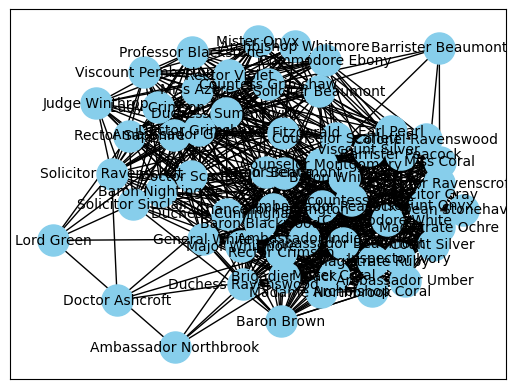

In [103]:
import networkx as nx

investigation_graph = nx.Graph()

for entry in investigation:
    investigation_graph.add_node(entry["name"])
for entry in investigation:
    for sighting in entry["sighting"]:
        investigation_graph.add_edge(entry["name"], sighting)

# Choose a layout (positions for each node)
position = nx.kamada_kawai_layout(investigation_graph)  # force reproducibility
# position = nx.shell_layout(investigation_graph)

# Draw nodes
nx.draw_networkx_nodes(investigation_graph, position, node_color='skyblue', node_size=500)

# Draw edges
nx.draw_networkx_edges(investigation_graph, position)

# Draw labels (node names)
nx.draw_networkx_labels(investigation_graph, position, font_size=10)

# Draw edge labels
edge_labels = nx.get_edge_attributes(investigation_graph, 'weight')
nx.draw_networkx_edge_labels(investigation_graph, position, edge_labels=edge_labels)

plot.figure(figsize=(500, 200))
plot.title("Investigation graph")
plot.axis('off')  # Hide axes
plot.show()

The graph is too crowded. Let's simplify it a bit.

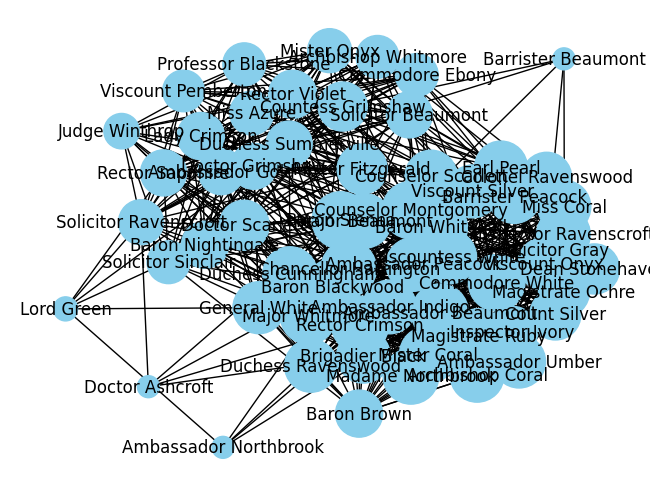

In [107]:
degrees = dict(investigation_graph.degree())
node_sizes = [degrees[n] * 50 for n in investigation_graph.nodes()]  # bigger for high degree

nx.draw(investigation_graph, position, node_size=node_sizes, node_color='skyblue', with_labels=True)


Making nodes larger can help a bit, but at this point we can filter just by plotting the nodes with the lowest degree: the murderer has probably a less solid alibi, so he/she mush not have many connections!

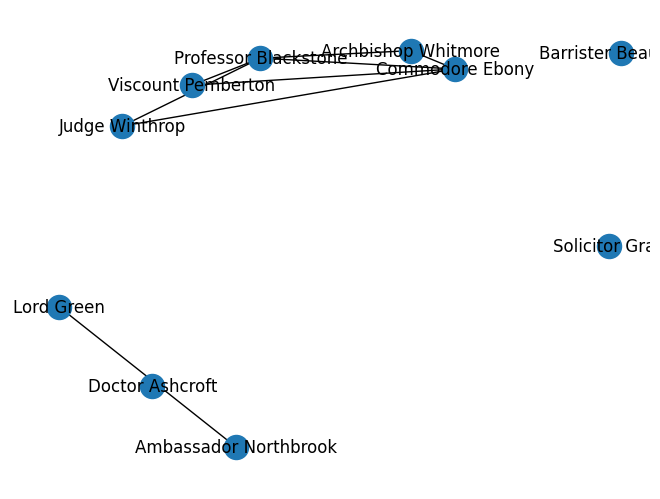

In [120]:
worst_nodes = sorted(degrees, key=degrees.get, reverse=False)[:10]
subgraph = investigation_graph.subgraph(worst_nodes)
pos = nx.shell_layout(subgraph)
nx.draw(subgraph, position, with_labels=True, node_size=300)


Let's try using Louvain algorithm for community detection. In this way we can show nodes clusters, which greatly simplifies the visualization.

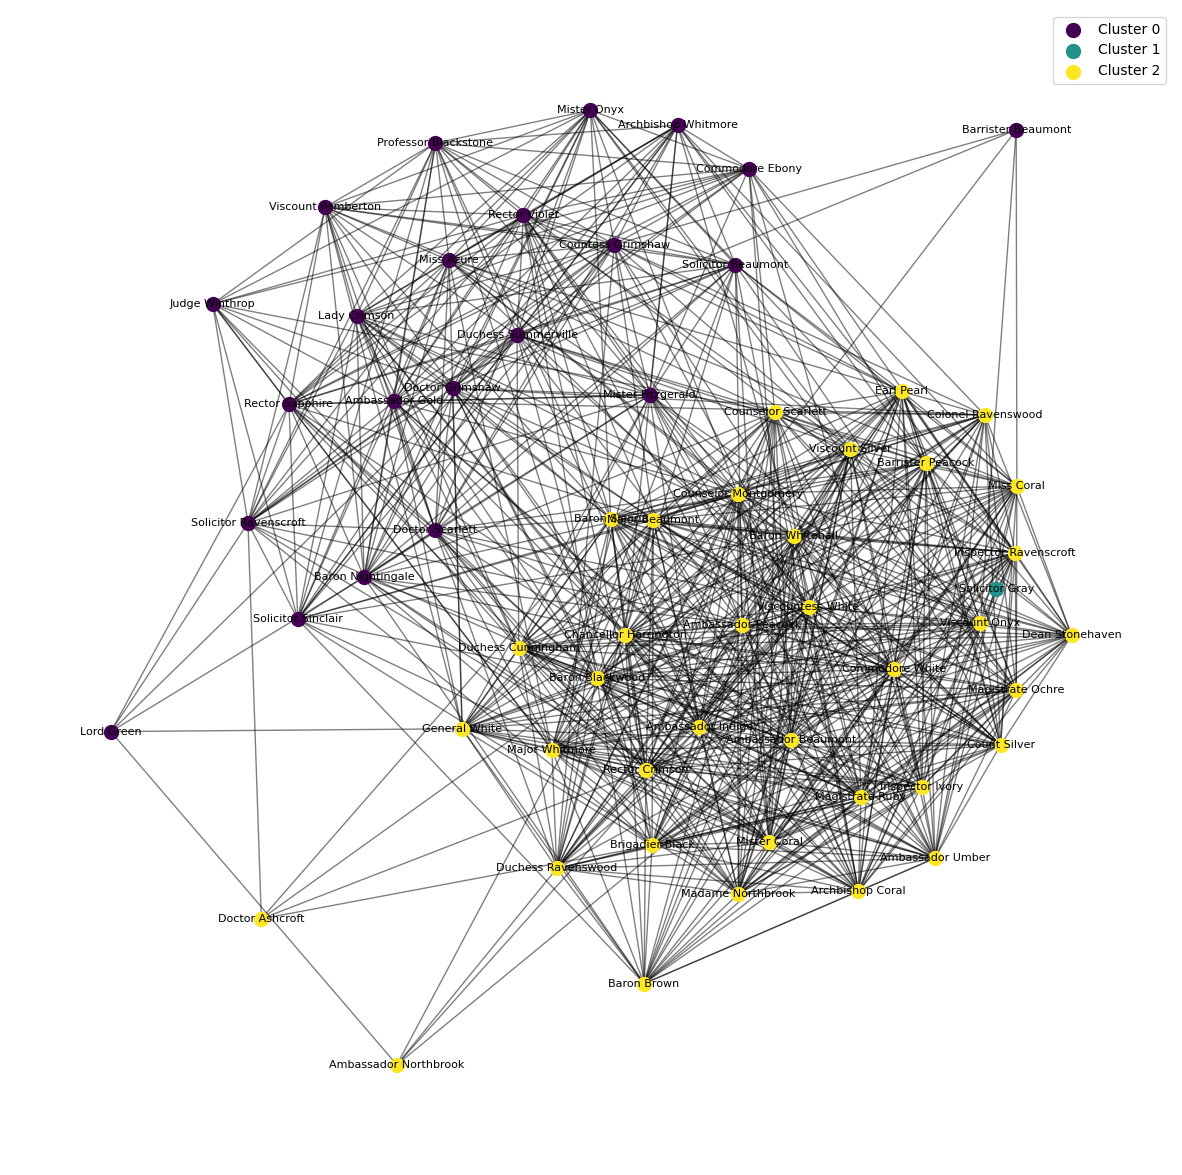

In [113]:
import community as community_louvain

# Compute the best partition (dict node -> cluster id)
partition = community_louvain.best_partition(investigation_graph)

# Draw nodes colored by their cluster
pos = nx.kamada_kawai_layout(investigation_graph)
cmap = plot.cm.get_cmap('viridis', max(partition.values()) + 1)

plot.figure(figsize=(15, 15))
for cluster_id in set(partition.values()):
    nodes = [node for node in partition if partition[node] == cluster_id]
    nx.draw_networkx_nodes(
        investigation_graph, pos, nodelist=nodes,
        node_size=100, node_color=[cmap(cluster_id)],
        label=f'Cluster {cluster_id}'
    )

nx.draw_networkx_edges(investigation_graph, pos, alpha=0.5)
nx.draw_networkx_labels(investigation_graph, pos, font_size=8)
plot.legend()
plot.axis('off')
plot.show()

Now we can apply the graph community clustering to the low-degree filter used before. This choice blends both the power of sightings relationships and the low-degree of sighthing which we can expect from the murderer.

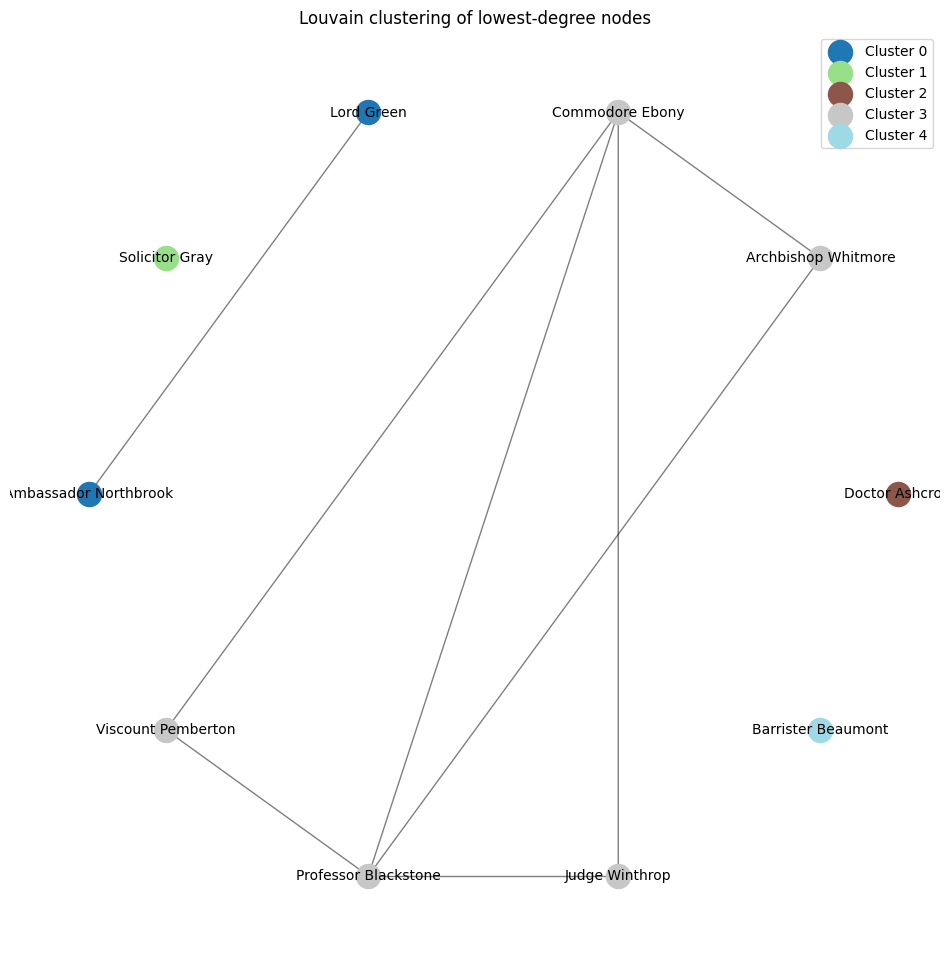

In [126]:
worst_nodes = sorted(degrees, key=degrees.get, reverse=False)[:10]
subgraph = investigation_graph.subgraph(worst_nodes)

partition = community_louvain.best_partition(subgraph)

position = nx.shell_layout(subgraph)
cmap = plot.cm.get_cmap('tab20', max(partition.values()) + 1)

plot.figure(figsize=(12, 12))
for cluster_id in set(partition.values()):
    nodes_in_cluster = [node for node in partition if partition[node] == cluster_id]
    nx.draw_networkx_nodes(
        subgraph, pos,
        nodelist=nodes_in_cluster,
        node_size=300,
        node_color=[cmap(cluster_id)],
        label=f'Cluster {cluster_id}'
    )

nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=10)
plot.legend()
plot.axis('off')
plot.title("Louvain clustering of lowest-degree nodes")
plot.show()

Viscount Pemberton seems to be the murderer because:
- its interrogation statement is close to the victim note style
- it has few sighthings related to him.

## Further possible refinements

- The investigation graph can be expanded to include location relationships
- We can use an LLM to get more context, in order to build an "implication graph" of possible lies or contradictions
- We can refine the embedding step in order to remove the parts of the statements which are less relevant to the murder dynamic